## Getting started
### GPU: 
NVIDIA RTX3070

### Pytorch:
I installed pytorch using pytorch.org install instructions:
<div class="alert alert-block alert-info">
<b> conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch </b>
</div>

### MONAI:
<div class="alert alert-block alert-info">
<b>pip install monai-weekly</b>
    </div>
 and then manually install dependcies such as
<div class="alert alert-block alert-info">
<b>pip install pytorch-ignite</b>
</div>


In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import math
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
import glob
from monai.config import print_config
from monai.data import Dataset, CacheDataset, DataLoader, decollate_batch


In [93]:
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.transforms import (
AddChanneld,
AsDiscrete,
AsDiscreted,
AsChannelFirst,
Compose,
CropForegroundd,
EnsureChannelFirst,    
EnsureChannelFirstd,
EnsureType,   
EnsureTyped,
Invertd,
LoadImage,
LoadImaged,
NormalizeIntensityd,
RandAdjustContrastd,
RandFlipd,
RandScaleIntensityd,
RandShiftIntensityd,
Resized,
SaveImaged,
ScaleIntensityRangePercentilesd,    
)

import pandas as pd
import torch

import warnings

In [59]:
print_config()

MONAI version: 0.9.dev2210
Numpy version: 1.20.3
Pytorch version: 1.10.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 1a660e6a7a50e985af5ff76b559baab44175438c
MONAI __file__: /home/mbcneuro/anaconda3/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.3
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [61]:
if os.path.exists('/media/'):
    directory = '/media/mbcneuro/HDD1/DWI_Training_Data/'
    ctp_df = pd.read_csv(
        '/home/mbcneuro/PycharmProjects/study_design/study_lists/dwi_inspire_dl.csv',
        index_col='dl_id'
    )

elif os.path.exists('D:'):
    directory = 'D:/ctp_project_data/DWI_Training_Data/'
    ctp_df = pd.read_csv(
        'C:/Users/fwerdiger/PycharmProjects/study_design/study_lists/dwi_inspire_dl.csv',
        index_col='dl_id')
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)


/media/mbcneuro/HDD1/DWI_Training_Data/


In [179]:
train_images, val_images, test_images = [
    glob.glob(os.path.join(root_dir, string, "images/*"))
             for string in ["train", "validation", "test"]]

In [196]:
train_images

['/media/mbcneuro/HDD1/DWI_Training_Data/train/images/image_001.nii.gz',
 '/media/mbcneuro/HDD1/DWI_Training_Data/train/images/image_002.nii.gz',
 '/media/mbcneuro/HDD1/DWI_Training_Data/train/images/image_003.nii.gz',
 '/media/mbcneuro/HDD1/DWI_Training_Data/train/images/image_004.nii.gz',
 '/media/mbcneuro/HDD1/DWI_Training_Data/train/images/image_005.nii.gz',
 '/media/mbcneuro/HDD1/DWI_Training_Data/train/images/image_006.nii.gz',
 '/media/mbcneuro/HDD1/DWI_Training_Data/train/images/image_007.nii.gz',
 '/media/mbcneuro/HDD1/DWI_Training_Data/train/images/image_008.nii.gz',
 '/media/mbcneuro/HDD1/DWI_Training_Data/train/images/image_009.nii.gz',
 '/media/mbcneuro/HDD1/DWI_Training_Data/train/images/image_010.nii.gz',
 '/media/mbcneuro/HDD1/DWI_Training_Data/train/images/image_011.nii.gz',
 '/media/mbcneuro/HDD1/DWI_Training_Data/train/images/image_012.nii.gz',
 '/media/mbcneuro/HDD1/DWI_Training_Data/train/images/image_013.nii.gz',
 '/media/mbcneuro/HDD1/DWI_Training_Data/train/imag

In [181]:
train_ds = Dataset(
    data=train_files,
    transform=None)

### Load up some example data without transforms

In [182]:
training_example = train_ds[0]
training_example

'/media/mbcneuro/HDD1/DWI_Training_Data/train/images/image_001.nii.gz'

### Load image and meta data into a tuple using LoadImage


In [183]:
loader = LoadImage()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    loaded_image = loader(image)

Image shape: (160, 160, 30, 2)
Image metadata keys: 
 dict_keys(['sizeof_hdr', 'extents', 'session_error', 'dim_info', 'dim', 'intent_p1', 'intent_p2', 'intent_p3', 'intent_code', 'datatype', 'bitpix', 'slice_start', 'pixdim', 'vox_offset', 'scl_slope', 'scl_inter', 'slice_end', 'slice_code', 'xyzt_units', 'cal_max', 'cal_min', 'slice_duration', 'toffset', 'glmax', 'glmin', 'qform_code', 'sform_code', 'quatern_b', 'quatern_c', 'quatern_d', 'qoffset_x', 'qoffset_y', 'qoffset_z', 'srow_x', 'srow_y', 'srow_z', 'affine', 'original_affine', 'as_closest_canonical', 'spatial_shape', 'original_channel_dim', 'filename_or_obj'])


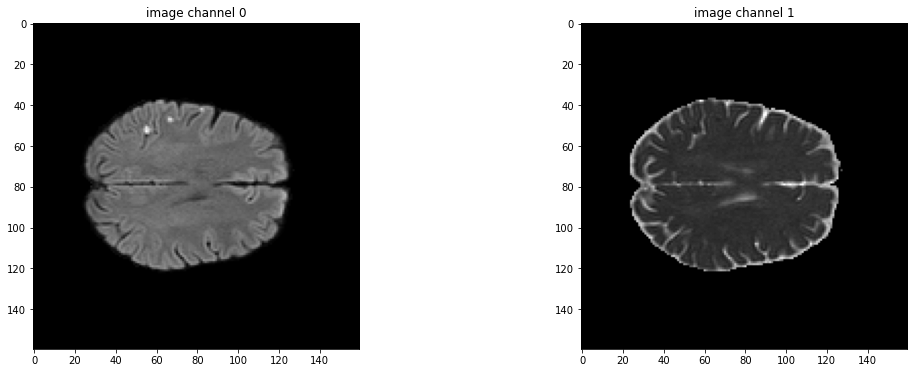

In [184]:
print(f"Image shape: {loaded_image[0].shape}")
print("Image metadata keys: \n {}".format(loaded_image[1].keys()))
plt.figure("image", (18, 6))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(loaded_image[0][:, :, 20, i], cmap="gray")

### Dictionary Transforms

In [189]:
def make_dict(root, string):
    images = sorted(
        glob.glob(os.path.join(root, string, 'images', '*.nii.gz'))
    )
    labels = sorted(
        glob.glob(os.path.join(root, string, 'masks', '*.nii.gz'))
    )
    return [
        {"image": image_name, "label": label_name}
        for image_name, label_name in zip(images, labels)
    ]


In [190]:
train_files, val_files, test_files = [
    make_dict(root_dir, string) for string in ['train', 'validation', 'test']]

In [191]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Resized(keys=["image", "label"],
                mode=['trilinear', "nearest"],
                align_corners=[True, None],
                spatial_size=(128, 128, 128)),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
#         RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
#         RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
#         RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
#         RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
#         RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
#         RandAdjustContrastd(keys="image", prob=1, gamma=(0.5, 1)),
        EnsureTyped(keys=["image", "label"]),
    ]
)


### Creating a dataset:

In [192]:
train_ds = Dataset(
    data=train_files,
    transform=train_transforms)

In [193]:
train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=4)

image shape: torch.Size([2, 128, 128, 128])
label shape: torch.Size([1, 128, 128, 128])


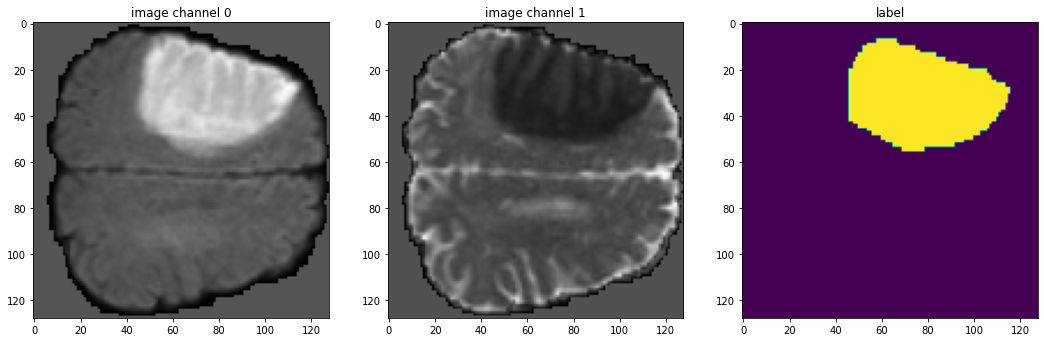

In [197]:
import random
m = random.randint(0, 222)
s = random.randint(20, 100)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_data_example = train_ds[m]
print(f"image shape: {train_data_example['image'].shape}")
plt.figure("image", (18, 6))
for i in range(2):
    plt.subplot(1, 3, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(train_data_example["image"][i, :, :, s].detach().cpu(), cmap="gray")
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {train_data_example['label'].shape}")
plt.subplot(1, 3, 3)
plt.title("label")
plt.imshow(train_data_example["label"][0, :, :, s].detach().cpu())